In [1]:
%matplotlib inline
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
from pandas.plotting import lag_plot
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from lib.metamodels import Metamodels
from scipy import stats, integrate
import seaborn as sns

sns.set(color_codes=True)
plt.rcParams['figure.figsize'] = [15, 10]


In [2]:
analysis_id = '66fb9766-26e7-4bed-bdf9-0fbfbc8d6c7e'
data_file = 'output/%s/simulation_results.csv' % analysis_id
if not os.path.exists(data_file):
    raise Exception("path does not exist")

print("Loaded data file: %s" % data_file)

 # data_file_to_csv()
dataset = pd.read_csv(data_file)
# this column is a redundant column
dataset = dataset.drop('DistrictCoolingOutletTemperature', 1)
# update some of the column names so they make sense to this model
dataset = dataset.rename(columns={
    'DistrictHeatingOutletTemperature': 'ETSInletTemperature',
    'DistrictHeatingInletTemperature': 'ETSHeatingOutletTemperature',
    'DistrictCoolingInletTemperature': 'ETSCoolingOutletTemperature',
})
# This command takes awhile to run... hang tight.
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])

Loaded data file: output/66fb9766-26e7-4bed-bdf9-0fbfbc8d6c7e/simulation_results.csv


In [3]:
dataset.columns.values

array(['DateTime', 'Month', 'Day', 'DayofWeek', 'Hour', 'Minute',
       'SiteOutdoorAirDrybulbTemperature',
       'SiteOutdoorAirRelativeHumidity', 'HeatingElectricity',
       'CoolingElectricity', 'ETSHeatingOutletTemperature',
       'ETSCoolingOutletTemperature', 'ETSInletTemperature',
       'DistrictHeatingMassFlowRate', 'DistrictCoolingMassFlowRate',
       'DistrictHeatingHotWaterEnergy',
       'DistrictCoolingChilledWaterEnergy', '_id',
       'ambient_loop_temperature_setpoint.design_delta',
       'ambient_loop_temperature_setpoint.setpoint_temperature',
       'openstudio_results.annual_peak_electric_demand',
       'openstudio_results.district_cooling_ip',
       'openstudio_results.district_heating_ip',
       'openstudio_results.electricity_ip', 'openstudio_results.eui',
       'openstudio_results.total_site_eui',
       'openstudio_results.unmet_hours_during_occupied_cooling',
       'openstudio_results.unmet_hours_during_occupied_heating'],
      dtype=object)

In [10]:
# load in the metamodels
rom = Metamodels('./metamodels.json')
rom.set_analysis(analysis_id)
# Load the exising models - If passed with list, then it will only load the models in the list.
rom.load_models()


Starting to load models, there are a total of 6 models
Loading model for response: ETSHeatingOutletTemperature
Finished loading models
The responses are:
  0: HeatingElectricity
  1: CoolingElectricity
  2: DistrictCoolingChilledWaterEnergy
  3: DistrictHeatingHotWaterEnergy
  4: ETSHeatingOutletTemperature
  5: ETSCoolingOutletTemperature
The covariates are:
  0: Month
  1: Hour
  2: DayofWeek
  3: SiteOutdoorAirDrybulbTemperature
  4: SiteOutdoorAirRelativeHumidity
  5: ETSInletTemperature
  6: DistrictHeatingMassFlowRate
  7: DistrictCoolingMassFlowRate


In [6]:
dataset._id.describe()

count                                   262800
unique                                      30
top       606171e5-3517-4ab1-85fe-276c34014eae
freq                                      8760
Name: _id, dtype: object

In [11]:
temperature_vars = [
       'ETSInletTemperature',
       'SiteOutdoorAirDrybulbTemperature',
       'ETSHeatingOutletTemperature',
       'ETSCoolingOutletTemperature',
       'ambient_loop_temperature_setpoint.setpoint_temperature',
       'ambient_loop_temperature_setpoint.design_delta',
     ]
temperature_series = dataset[temperature_vars]
temperature_series.describe()



,ETSInletTemperature,SiteOutdoorAirDrybulbTemperature,ETSHeatingOutletTemperature,ETSCoolingOutletTemperature,ambient_loop_temperature_setpoint.setpoint_temperature,ambient_loop_temperature_setpoint.design_delta
count,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000,262800.000000
mean,22.103454,11.196929,21.749915,21.749915,19.983271,3.755242
std,4.526443,10.005738,4.804681,4.804681,2.863695,1.888244
min,11.469700,-16.100000,11.469500,11.469500,15.186900,0.608471
25%,18.895300,3.300000,18.476800,18.476800,17.564989,2.106256
50%,22.189200,10.600000,21.500700,21.500700,19.897556,3.748739
75%,25.754200,17.800000,25.754200,25.754200,22.387736,5.391200
max,31.717500,38.300000,31.717500,31.717500,24.721784,6.979553


(array([1, 2, 3, 4, 5, 6]), <a list of 6 Text xticklabel objects>)

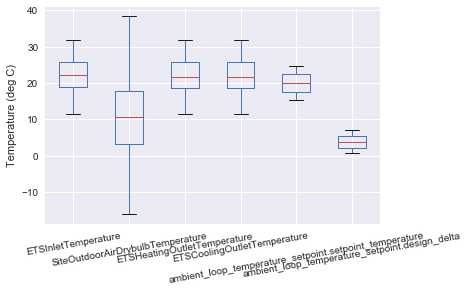

In [15]:
temperature_series.plot.box()
plt.ylabel("Temperature (deg C)")
plt.xticks(rotation=10)

In [13]:
mass_flow_series = dataset[[
  'DistrictCoolingMassFlowRate',  
  'DistrictHeatingMassFlowRate',
]]
mass_flow_series[mass_flow_series.DistrictCoolingMassFlowRate > 0].describe()
#mass_flow_series[mass_flow_series.DistrictCoolingMassFlowRate > 0].plot.box()
#mass_flow_series.plot.box()



,DistrictCoolingMassFlowRate,DistrictHeatingMassFlowRate
count,52637.000000,52637.000000
mean,0.721729,0.000662
std,0.910419,0.007987
min,0.000114,0.000000
25%,0.163268,0.000000
50%,0.457321,0.000000
75%,0.858956,0.000000
max,7.514100,0.541783


In [16]:
# get the time series data for 3/15
dataset.set_index('DateTime')
dataset.DateTime.describe()
# dataset.DateTime[15]

count                  262800
unique                   8760
top       2009-10-18 13:00:00
freq                       30
first     2009-01-01 01:00:00
last      2010-01-01 00:00:00
Name: DateTime, dtype: object

In [19]:
ds = dataset[dataset["DateTime"].between("2009-03-01 01:00", "2009-03-10 00:00")]

# constrain to a specific building
ds_single_building = ds[ds._id == '606171e5-3517-4ab1-85fe-276c34014eae']

# Add in the ROM results into the single building
# ds_single_building['RF_HeatingElectricity'] = rom.yhat('HeatingElectricity', ds_single_building)
ds_single_building['RF_ETSHeatingOutletTemperature'] = rom.yhat('ETSHeatingOutletTemperature', ds_single_building)
ds_single_building.iloc[0]

The following columns are not needed in DataFrame
['ETSHeatingOutletTemperature', 'DistrictCoolingChilledWaterEnergy', 'ETSCoolingOutletTemperature', 'HeatingElectricity', 'openstudio_results.unmet_hours_during_occupied_heating', 'openstudio_results.eui', 'openstudio_results.total_site_eui', 'openstudio_results.annual_peak_electric_demand', 'DateTime', 'ambient_loop_temperature_setpoint.setpoint_temperature', 'openstudio_results.district_heating_ip', 'openstudio_results.district_cooling_ip', 'openstudio_results.electricity_ip', 'openstudio_results.unmet_hours_during_occupied_cooling', 'ambient_loop_temperature_setpoint.design_delta', 'CoolingElectricity', '_id', 'Day', 'Minute', 'DistrictHeatingHotWaterEnergy']
Removing unneeded column before evaluation


/Users/nlong/.pyenv/versions/2.7.14/envs/data-analysis-2.7/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


DateTime                                                                   2009-03-01 01:00:00
Month                                                                                        3
Day                                                                                          1
DayofWeek                                                                                    0
Hour                                                                                         1
Minute                                                                                       0
SiteOutdoorAirDrybulbTemperature                                                           7.8
SiteOutdoorAirRelativeHumidity                                                              73
HeatingElectricity                                                                           0
CoolingElectricity                                                                           0
ETSHeatingOutletTemperature                       

In [72]:
sns.set(style="darkgrid")
temps_single_buildings = ds_single_building[
    temperature_vars + ['DateTime', 'RF_ETSHeatingOutletTemperature', 'DistrictHeatingMassFlowRate', 'DistrictCoolingMassFlowRate']
]
temps_single_buildings.describe()

,ETSInletTemperature,SiteOutdoorAirDrybulbTemperature,ETSHeatingOutletTemperature,ETSCoolingOutletTemperature,ambient_loop_temperature_setpoint.setpoint_temperature,ambient_loop_temperature_setpoint.design_delta,RF_ETSHeatingOutletTemperature,DistrictHeatingMassFlowRate,DistrictCoolingMassFlowRate
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,16.816664,6.334722,16.322395,16.322395,17.564989,3.086545,16.268596,0.040018,0.000087
std,1.187690,4.890774,1.214378,1.214378,0.000000,0.000000,1.248880,0.114931,0.000840
min,15.435000,-3.900000,15.403900,15.403900,17.564989,3.086545,14.664290,0.000000,0.000000
25%,15.435400,2.800000,15.435200,15.435200,17.564989,3.086545,15.435104,0.000000,0.000000
50%,17.565000,7.200000,15.435800,15.435800,17.564989,3.086545,15.435104,0.000000,0.000000
75%,18.090200,10.000000,18.090200,18.090200,17.564989,3.086545,18.090200,0.000233,0.000000
max,18.533400,17.800000,18.533400,18.533400,17.564989,3.086545,18.538799,0.729022,0.011642


Text(0.5,1,u'RF vs EnergyPlus Outlet Temperature')

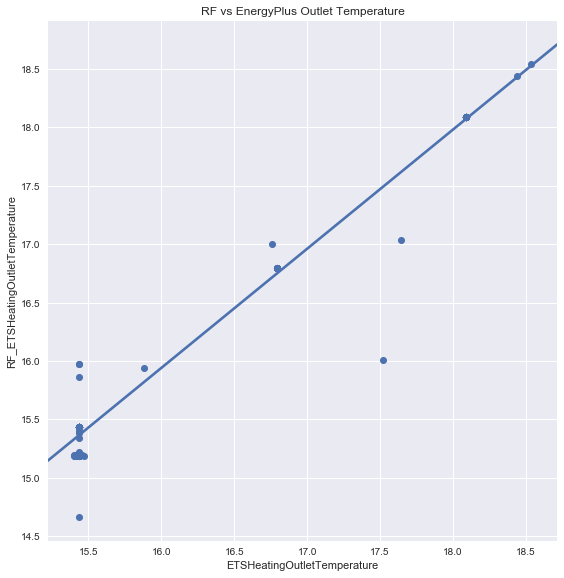

In [79]:
# plot the RF ETS Outlet  with the ETSOutput
newplt = sns.lmplot(x="ETSHeatingOutletTemperature", y="RF_ETSHeatingOutletTemperature", data=temps_single_buildings,
           ci=None, palette="muted", size=8, scatter_kws={"s": 50, "alpha": 1})
newplt = newplt.axes.flatten()
newplt[0].set_title("RF vs EnergyPlus Outlet Temperature")

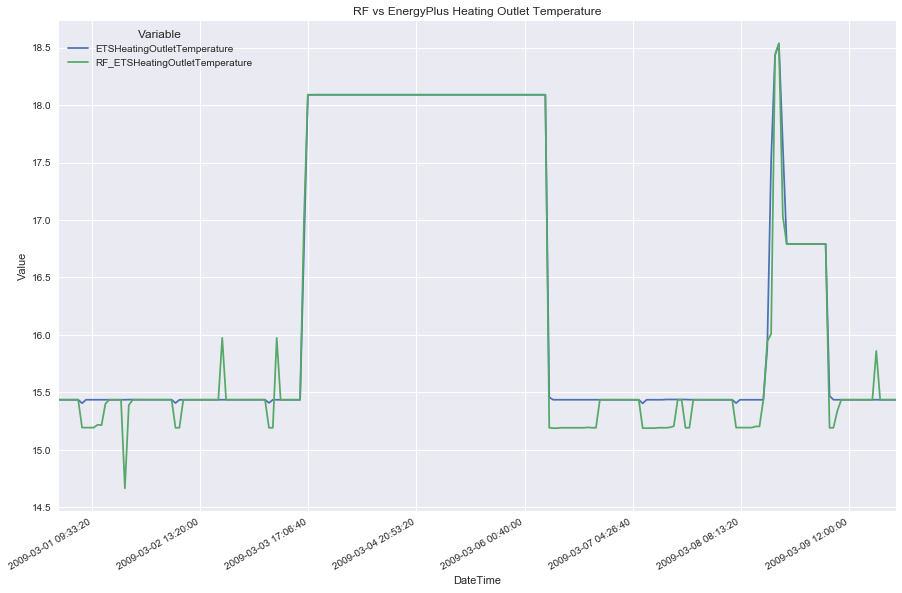

In [74]:
#selected_columns = ['DateTime', 'ETSHeatingOutletTemperature','RF_ETSHeatingOutletTemperature', 'DistrictHeatingMassFlowRate', 'DistrictCoolingMassFlowRate']
selected_columns = ['DateTime', 'ETSHeatingOutletTemperature','RF_ETSHeatingOutletTemperature']
melted_df = pd.melt(temps_single_buildings[selected_columns], id_vars='DateTime', var_name='Variable', value_name='Value')
melted_df['Dummy'] = 0

def date_formatter(x, pos):
    return pd.to_datetime(x)

fig, ax = plt.subplots()

newplt = sns.tsplot(melted_df, time='DateTime', unit='Dummy', condition='Variable', value='Value', ax=ax)
newplt.set_title("RF vs EnergyPlus Heating Outlet Temperature")
ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(date_formatter))

# put the labels at 45deg since they tend to be too long
fig.autofmt_xdate()
plt.show()

In [97]:
ds_single_building.columns.values



array(['DateTime', 'Month', 'Day', 'DayofWeek', 'Hour', 'Minute',
       'SiteOutdoorAirDrybulbTemperature',
       'SiteOutdoorAirRelativeHumidity', 'HeatingElectricity',
       'CoolingElectricity', 'ETSHeatingOutletTemperature',
       'ETSCoolingOutletTemperature', 'ETSInletTemperature',
       'DistrictHeatingMassFlowRate', 'DistrictCoolingMassFlowRate',
       'DistrictHeatingHotWaterEnergy',
       'DistrictCoolingChilledWaterEnergy', '_id',
       'ambient_loop_temperature_setpoint.design_delta',
       'ambient_loop_temperature_setpoint.setpoint_temperature',
       'openstudio_results.annual_peak_electric_demand',
       'openstudio_results.district_cooling_ip',
       'openstudio_results.district_heating_ip',
       'openstudio_results.electricity_ip', 'openstudio_results.eui',
       'openstudio_results.total_site_eui',
       'openstudio_results.unmet_hours_during_occupied_cooling',
       'openstudio_results.unmet_hours_during_occupied_heating',
       'RF_HeatingElectric

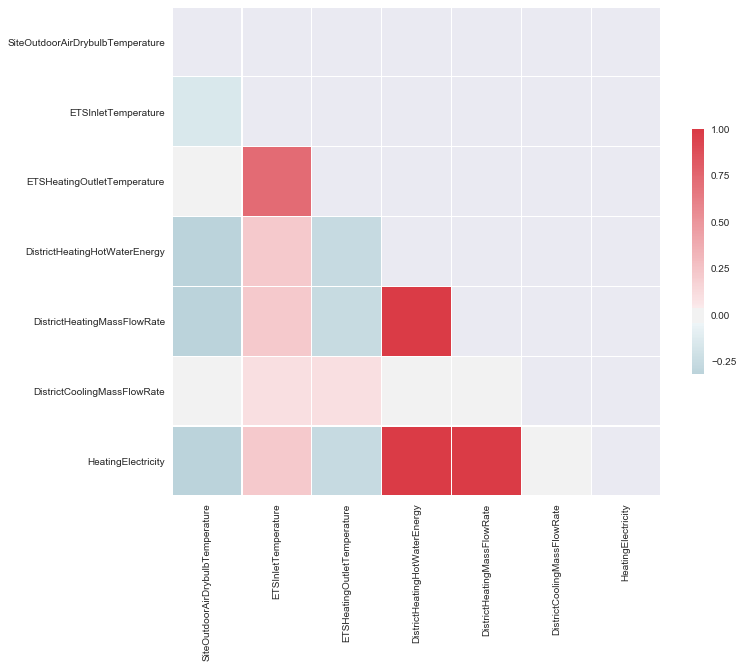

In [108]:
d = pd.DataFrame(data=ds_single_building, 
                 columns=[
                     'SiteOutdoorAirDrybulbTemperature',
                     'ETSInletTemperature',
                     'ETSHeatingOutletTemperature',
                     'DistrictHeatingHotWaterEnergy',
                     'DistrictHeatingMassFlowRate',
                     'DistrictCoolingMassFlowRate',
                     'HeatingElectricity',
                 ])

# Compute the correlation matrix
corr = d.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})